<a href="https://colab.research.google.com/github/stochasticats/imdb-review-sentiment-classifier/blob/master/imdb_movie_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDb Movie Review Sentiment Classification
This Google colab notebook is for developing a deep learning model to classify movie reviews as positive or negative using the data set provided here http://ai.stanford.edu/~amaas/data/sentiment/

First we establish the libraries to be used.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2.2.0


First download the zipped data from ai.stanford

In [2]:
!wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2020-06-02 01:39:26--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.8MB/s    in 7.6s    

2020-06-02 01:39:34 (10.6 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
%%capture
!tar -xvf "/content/aclImdb_v1.tar.gz"

Here I establish stopwords, these are words that will add no meaning to the reviews and will be removed.

In [0]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# Load Data and Data Preprocessing

Let's load the training data, which is conveniently in two folders based on the sentiment classification.

In [0]:
loc = '/content/aclImdb/train/pos'
os.chdir(loc)
filelist = os.listdir()

reviews_pos = []
labels_pos = []

for f in filelist:
  with open (f, "r") as myfile:
    labels_pos.append(1)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    reviews_pos.append(review)

loc = '/content/aclImdb/train/neg'
os.chdir(loc)
filelist = os.listdir()

reviews_neg = []
labels_neg = []

for f in filelist:
  with open (f, "r") as myfile:
    labels_neg.append(0)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    reviews_neg.append(review)

In [6]:
randn = random.randint(0,len(reviews_pos))

print("Length of reviews that are positive:")
print(len(reviews_pos))
print("Example of a positive review:")
print(reviews_pos[randn])
print("The label:")
print(labels_pos[randn])
print("Length of reviews that are negative:")
print(len(reviews_neg))
print("Example of a negative review:")
print(reviews_neg[randn])
print("The label:")
print(labels_neg[randn])

Length of reviews that are positive:
12500
Example of a positive review:
Remember early days Pay Per View? I do, can almost remember number CALL actually rent movie t.v. As kid always wanted rent playboy, meant actually calling someone PPV asking rent it. And get nerve watching four hours soft core no angle crap. Well reason bring movie ppv. And remember almost every scene add. I've kick last years obtain great movies use see kid one them. It's one hard shut off. All star cast trying commit perfect bank bust nothing goes right. There plenty spoof bank capers good one fall category. It enough action laughs sustain it. check dare!
The label:
1
Length of reviews that are negative:
12500
Example of a negative review:
I say I hated movie. I don't like say Gerard Butler it. About half hour boring conversation, sorry actually care plot, I started fast-forwarding Gerry's scenes. I really don't know ending, I bored it. If Gerry wasn't it, I probably either done one two things: fell asleep turne

We have 25,000 reviews in total, 12,500 positive and 12,500 negative. As we can see, our reviews need some processing for the deep learning model.  We need to take out the digits and special characters.

Here's a function to use to process the data.

In [0]:
import spacy
import re,string,unicodedata

def preprocess(text):
    text = re.sub('<[^>]*>', '',text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text=re.sub('[\W]+',' ',text.lower()) +\
       ' '.join(emoticons).replace('-','')  
    return text

In [0]:
reviews = reviews_pos + reviews_neg
labels = labels_pos + labels_neg

In [0]:
denoised_reviews = []

for review in reviews:
  denoised_reviews.append(preprocess(review))

Let's put it into a single data frame and take a look.

In [0]:
dataframe = pd.DataFrame(
    {'reviews': denoised_reviews,
     'labels': labels,
    })
from sklearn.utils import shuffle
dataframe = shuffle(dataframe).reset_index(drop=True)

In [11]:
dataframe.head(20)

,reviews,labels
0,it not easy film watch three half hours long c...,1
1,imagine hampered bureaucracy one man spends 8 ...,1
2,this film much rip off masterpeice demons that...,0
3,rawhide wonderful tv western series focusing b...,1
4,burt reynolds came point career appeared just ...,0
5,i fell love silent action drama kurt russell k...,1
6,marlon brando long since lost interest acting ...,0
7,why star reaches top star chain ruin good work...,0
8,this movie really great flick something affect...,1
9,after success part 4 another sequel natural mo...,0


Let's take a look at the distribution of review length.

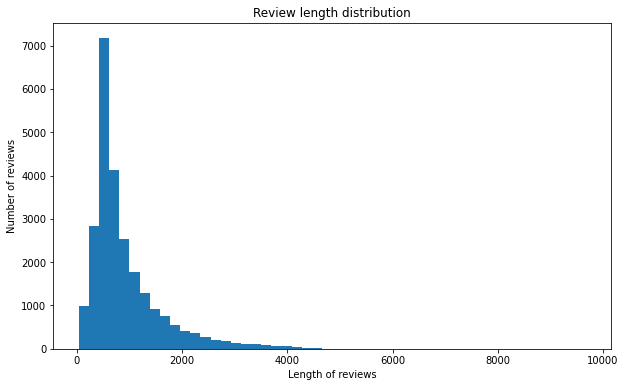

In [12]:
plt.figure(figsize=(10, 6))
plt.hist([len(review) for review in dataframe['reviews']], 50)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Review length distribution')
plt.show()

There seems to be a peak at around length ~1000, meaning there's a lot of reviews with length ~1000. 

In [0]:
vocab_size = 8000
embedding_dim = 128
max_length = 3000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(dataframe['reviews'], dataframe['labels'], test_size=0.2, random_state=42)

In [15]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

20000
20000
5000
5000


In [16]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seqs, padding=padding_type, maxlen=max_length)

print(len(X_train_seqs[0]))
print(len(X_train_padded[0]))

print(len(X_train_seqs[600]))
print(len(X_train_padded[600]))

print(len(X_train_seqs[10000]))
print(len(X_train_padded[10000]))

424
3000
83
3000
50
3000


In [17]:
X_valid_seqs = tokenizer.texts_to_sequences(X_valid)
X_valid_padded = pad_sequences(X_valid_seqs, padding=padding_type, maxlen=max_length)

print(len(X_valid_seqs))
print(X_valid_padded.shape)

5000
(5000, 3000)


# Deep Learning Model

Here I build the deep learning model. 

First we start with an embedding layer so that the network learns the embedding space our vocabulary lives in. Words or phrases are mapped to vectors of real numbers. The embedding layer is a dimensionality reduction technique used to take the size of vocabulary to a vector space with much lower dimension.

Then the data is fed into dense layers.

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(256, 5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(128, 5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(64, 5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(32, 5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3000, 128)         1024000   
_________________________________________________________________
conv1d (Conv1D)              (None, 2996, 256)         164096    
_________________________________________________________________
batch_normalization (BatchNo (None, 2996, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 2996, 256)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 599, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 595, 128)          163968    
_________________________________________________________________
batch_normalization_1 (Batch (None, 595, 128)          5

Let's set up some callbacks. Callbacks:

**EarlyStopping** - stop early if the validation loss has stopped improving

**ModelCheckpoint** - save the model every epoch and save the best weights

**ReduceLROnPlateau** - reduce learning rate when validation loss has stopped improving

**LearningRateScheduler** - set learning rate to ramp up during early epochs


Learning rate per epoch:


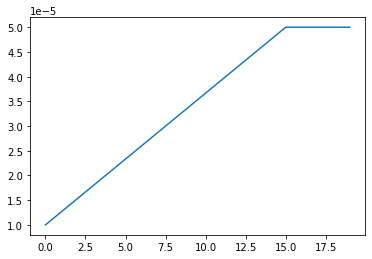

In [19]:
es = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1)

epochs = 20
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 15
sustain_epochs = 10
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return min_lr
    
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [20]:
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=128, validation_data=(X_valid_padded, y_valid), verbose=1, callbacks=[mc])

Epoch 1/20
157/157 [==============================] - 33s 211ms/step - loss: 0.5203 - accuracy: 0.7620 - val_loss: 0.7342 - val_accuracy: 0.4916
Epoch 2/20
157/157 [==============================] - 33s 207ms/step - loss: 0.2565 - accuracy: 0.9262 - val_loss: 0.6247 - val_accuracy: 0.5852
Epoch 3/20
157/157 [==============================] - 33s 208ms/step - loss: 0.1112 - accuracy: 0.9829 - val_loss: 0.4538 - val_accuracy: 0.8578
Epoch 4/20
157/157 [==============================] - 33s 208ms/step - loss: 0.0425 - accuracy: 0.9981 - val_loss: 0.3473 - val_accuracy: 0.8670
Epoch 5/20
157/157 [==============================] - 33s 208ms/step - loss: 0.0181 - accuracy: 0.9998 - val_loss: 0.2876 - val_accuracy: 0.8808
Epoch 6/20
157/157 [==============================] - 32s 206ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 0.8798
Epoch 7/20
157/157 [==============================] - 32s 207ms/step - loss: 0.0067 - accuracy: 0.9999 - val_loss: 0.3118 - val_ac

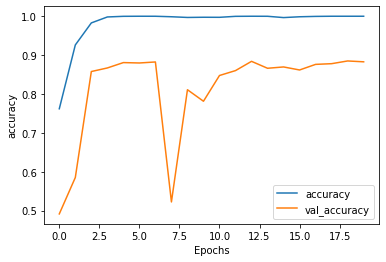

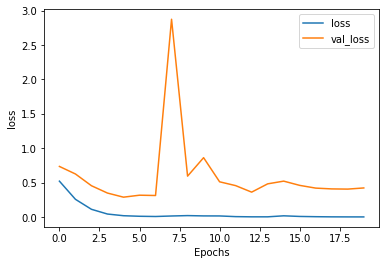

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
loc = '/content/aclImdb/test/pos'
os.chdir(loc)
filelist = os.listdir()

test_reviews_pos = []
test_labels_pos = []

for f in filelist:
  with open (f, "r") as myfile:
    test_labels_pos.append(1)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    test_reviews_pos.append(review)

loc = '/content/aclImdb/test/neg'
os.chdir(loc)
filelist = os.listdir()

test_reviews_neg = []
test_labels_neg = []

for f in filelist:
  with open (f, "r") as myfile:
    test_labels_neg.append(0)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    test_reviews_neg.append(review)

In [0]:
test_reviews = test_reviews_pos + test_reviews_neg
test_labels = test_labels_pos + test_labels_neg

denoised_test_reviews = []

for review in test_reviews:
  denoised_test_reviews.append(preprocess(review))

dataframe_test = pd.DataFrame(
    {'reviews': denoised_test_reviews,
     'labels': test_labels,
    })

In [0]:
dataframe_test = shuffle(dataframe_test).reset_index(drop=True)

In [0]:
test_sentences = dataframe_test['reviews']
test_labels = dataframe_test['labels']

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [27]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 15s 20ms/step - loss: 0.4671 - accuracy: 0.8671
Test loss: 0.4671429991722107
Test accuracy: 0.8670799732208252


In [28]:
Review = 'Where to begin? This headliner at the Fecal Film Festival is without a doubt the worst thing I have ever seen. Entirely without any redeeming value whatsoever, not even camp value mind you... this film lacks any substantive plot or story line that is discernable, nor comprehendable dialogue, nor even interest as a soft core porno.' #@param {type:"string"}
Review = preprocess(Review)
Review = tokenizer.texts_to_sequences([Review])
Review = pad_sequences(Review, padding=padding_type, maxlen=max_length)
prediction = model.predict(Review)
print(prediction)

[[0.00023831]]
